# Image Classification using ImageNette

> Image Classification using ImageNette


- skip_showdoc: true
- skip_exec: true

## Data Preprocessing

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, utils
from torch.utils.data import DataLoader

import torch

from tqdm import tqdm 
import matplotlib.pyplot as plt
import timm
import numpy as np
from datetime import datetime

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# Define the transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std

])

# Download and load the Imagenette dataset
train_dataset = datasets.Imagenette(root='Data',
                                    split='train',
                                    # download=True,
                                    transform=transform,
                                    )


# Download and load the Imagenette dataset
test_dataset = datasets.Imagenette(root='Data',
                                  split='val',
                                  # download=True,
                                  transform=transform,
                                 )

In [ ]:
train_dataset.__dict__.keys()

dict_keys(['root', 'transform', 'target_transform', 'transforms', '_split', '_size', '_url', '_md5', '_size_root', '_image_root', 'wnids', 'wnid_to_idx', 'classes', 'class_to_idx', '_samples'])

In [ ]:
train_dataset.classes

[('tench', 'Tinca tinca'),
 ('English springer', 'English springer spaniel'),
 ('cassette player',),
 ('chain saw', 'chainsaw'),
 ('church', 'church building'),
 ('French horn', 'horn'),
 ('garbage truck', 'dustcart'),
 ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'),
 ('golf ball',),
 ('parachute', 'chute')]

In [ ]:
len(train_dataset), len(test_dataset)

(9469, 3925)

In [ ]:
images, labels = train_dataset[10]
images.shape

torch.Size([3, 150, 150])

In [ ]:
# Define a function to display images
def show_image(dataset):
    # Access an image and its label from the dataset
    image, label = dataset
    
    # Convert the image tensor to a NumPy array
    image_np = image.numpy().transpose((1, 2, 0))

    # Display the image using Matplotlib
    plt.imshow(image_np)
    plt.axis('off')
    plt.title(f' {train_dataset.classes[label][0]}')
    plt.show()
    
   
# Define a function to display images
def show_images(images, labels, **kwargs):
    nrows = int(np.ceil(np.sqrt(len(images))))
    ncols = int(np.ceil(len(images)/nrows))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12),  **kwargs)
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    for ax, image, label in zip(axes.flat, images, labels):
        # Convert image to numpy array and adjust pixel values
        img_np = image.numpy().transpose((1, 2, 0))
        
        # Display image
        ax.imshow(img_np)
        ax.axis('off')
        ax.set_title(f' {train_dataset.classes[label][0]}')
    for ax in axes.flat[len(images):]:
        ax.axis('off')
        
    plt.show()

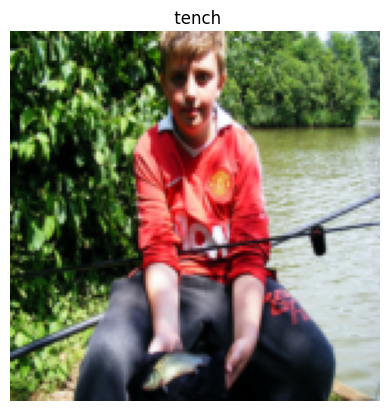

In [ ]:
show_image(train_dataset[2])

In [ ]:
def loaders(batch_size):

    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=8)
    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False, 
                             num_workers=8)
    
    dataloaders = {'train': train_loader, 'val': test_loader}
    dataset_sizes = {'train': len(train_dataset), 'val': len(test_dataset) }
    return train_loader, test_loader, dataloaders, dataset_sizes

In [ ]:
batch_size = 32
train_loader, test_loader, dataloaders, dataset_sizes = loaders(batch_size)

In [ ]:
# Get a batch of images and labels from the data loader
examples = iter(test_loader)
images, labels = next(examples)
# ############## TENSORBOARD ########################
# img_grid = utils.make_grid(images)

# writer.add_image('Imagenette', img_grid)
# writer.flush()
# #sys.exit()
# ###################################################

In [ ]:
len(images)

32

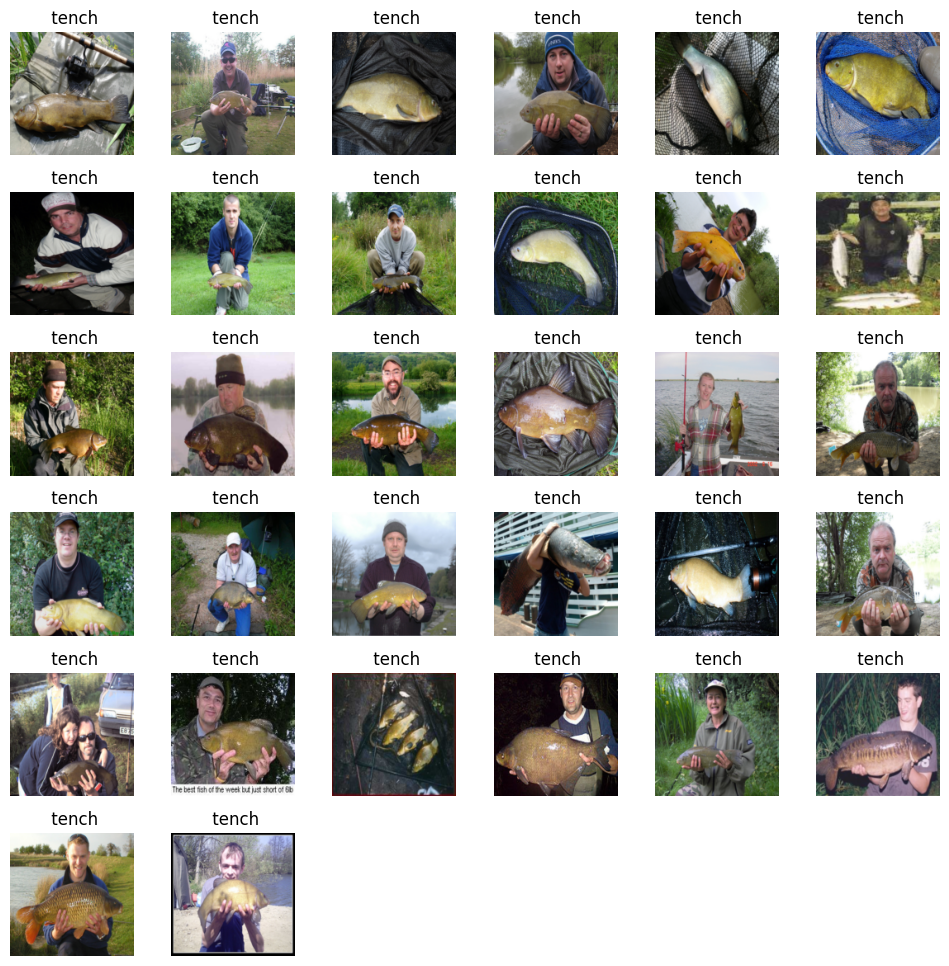

In [ ]:
show_images(images, labels)

## Model

In [ ]:
def train_model(model, criterion, 
                optimizer, scheduler, 
                train_loader, epoch,
                n_total_steps, record = 10):
    running_loss = 0.0
    running_correct = 0
    model.train()
    for i, (images, labels) in enumerate(tqdm(train_loader)):  
        
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()
        if (i+1) % record == 0:
            ############## TENSORBOARD ########################
            writer.add_scalar('training loss', running_loss / record, epoch * n_total_steps + i)
            running_accuracy = running_correct / record / len(images)
            writer.add_scalar('training accuracy', running_accuracy, epoch * n_total_steps + i)
            running_correct = 0
            running_loss = 0.0
            writer.flush()
            ###################################################
    scheduler.step()
    

def eval_model(model, criterion, 
               optimizer, scheduler, 
               test_loader, epoch,
               n_total_steps, batch_size):
    running_loss = 0.0
    running_correct = 0
    running_accuracy = 0
    
    model.eval()
    len_batch = 0
    for i, (images, labels) in enumerate(tqdm(test_loader)):  
        images = images.to(device)
        labels = labels.to(device)
        len_batch = len(images)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()
        
    ############## TENSORBOARD ########################
    writer.add_scalar('val loss',
                      running_loss / len(test_loader),
                      (epoch+1) * n_total_steps)
    running_accuracy = running_correct / len(test_loader) / batch_size
    writer.add_scalar('val accuracy',
                      running_accuracy,
                      (epoch+1) * n_total_steps)

    writer.flush()
    ###################################################

In [ ]:
def build_model(model, criterion, optimizer,
                scheduler, num_epochs=5, batch_size = 32, record = 10):
    
    train_loader, test_loader, _, _ = loaders(batch_size)

    model = model.to(device)

    n_total_steps = len(train_loader)
    for epoch in range(num_epochs):
        train_model(model, criterion,
                    optimizer, scheduler,
                    train_loader, epoch,
                    n_total_steps, record = 10)

        eval_model(model, criterion, 
                   optimizer, scheduler, 
                   test_loader, epoch, 
                   n_total_steps, batch_size)

    return model

## default setup

In [ ]:
model = timm.create_model('resnet18',
                          pretrained=True,
                          num_classes=10)


In [ ]:
learning_rate = 0.1
num_epochs = 5
batch_size = 64
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [ ]:
############## TENSORBOARD ########################
import sys
from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
formatted_time =  datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

writer = SummaryWriter(log_dir = f'runs/transforms {formatted_time}')

writer.add_text('learning_rate', f'{learning_rate}')
writer.add_text('epochs', f'{num_epochs}')
writer.add_text('batch_size', f'{batch_size}')
writer.add_text('criterion', f'{str(criterion)}')
writer.add_text('optimizer', f'{str(optimizer)}')

writer.add_graph(model, images)
writer.flush()
###################################################

In [ ]:
model = build_model(model = model,
                    criterion = criterion,
                    optimizer = optimizer,
                    scheduler = step_lr_scheduler,
                    num_epochs = num_epochs,
                    batch_size = batch_size,
                    record = 20)

100%|███████████████████████████████████████████████████████████████████████████████████| 62/62 [00:04<00:00, 13.88it/s]


In [ ]:
del model
torch.cuda.empty_cache()

In [ ]:
############## TENSORBOARD ########################
writer.close()
###################################################

## Test Loop

In [ ]:
# learning_rate = 0.1
# num_epochs = 5
# batch_size = 64
# criterion = nn.CrossEntropyLoss()

In [ ]:
# for a in range(1):
#     model = timm.create_model('resnet18',
#                           pretrained=True,
#                           num_classes=10)
#     # optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
#     optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
#     step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
    
#     ######################## TENSORBOARD ########################
#     import sys
#     from torch.utils.tensorboard import SummaryWriter
#     # default `log_dir` is "runs" - we'll be more specific here
#     formatted_time =  datetime.now().strftime("%H:%M:%S")
    
#     writer = SummaryWriter(log_dir = f'runs/transforms {formatted_time}')
#     print(f'runs/transforms {formatted_time}')
    
#     writer.add_text('learning_rate', f'{learning_rate}')
#     writer.add_text('epochs', f'{num_epochs}')
#     writer.add_text('batch_size', f'{batch_size}')
#     writer.add_text('criterion', f'{str(criterion)}')
#     writer.add_text('optimizer', f'{str(optimizer)}')
    
#     # writer.add_graph(model, images)
#     writer.flush()
#     ###################################################


#     model = build_model(model = model,
#                         criterion = criterion,
#                         optimizer = optimizer,
#                         scheduler = step_lr_scheduler,
#                         num_epochs = num_epochs,
#                         batch_size = batch_size,
#                         record = 20)
#     del model
#     torch.cuda.empty_cache()
    
#     ######################## TENSORBOARD ########################
#     writer.close()
#     ###################################################


runs/optimizer Adam 23:59:40


100%|███████████████████████████████████████████████████████████████████████████████████| 62/62 [00:04<00:00, 12.99it/s]
